# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
# Import neccesaary libraries
import os
import time

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim import SGD  
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet152, resnet18

In [2]:
# Settings and configurations
@dataclass
class SystemConfiguration:
    seed:int = 21
        
# Specifiy all the data needed in dataclass named TrainingConfiguration
@dataclass
class TrainingConfiguration:
    batch_size: int =20
    epoch_count: int = 20
    init_learning_rate: float = 0.001
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "/kaggle/input/opencv-pytorch-dl-course-classification/"
    model_dir: str = '/kaggle/working/models/'
    log_dir: str = '/kaggle/working/logs'
    annotation_file: str = data_root + "train.csv"
    test_csv_file: str = data_root + "test.csv"
    img_dir: str = data_root + "images/images/"
    submission_csv: str = '/kaggle/working/submission.csv'
    num_workers: int = 2
    device: str = 'cuda'
    train_split: float = 0.8
    random_seed: int = 42
    model_name: str = "resnet152"
    lr: float =0.001
    #below is calculated from KenyanFood13 pictures
    #mean: torch.tensor = torch.tensor([0.5768, 0.4622, 0.3460])
    #std: torch.tensor = torch.tensor([0.2699, 0.2739, 0.2826])
    
    #below mean and standard are for Resnet18 https://pytorch.org/hub/pytorch_vision_resnet/
    mean: torch.tensor = torch.tensor([0.485, 0.456, 0.406])
    std: torch.tensor  = torch.tensor([0.229, 0.224, 0.225])
        
    tb_writer: SummaryWriter = SummaryWriter(log_dir)
    criterion: torch.nn.CrossEntropyLoss = torch.nn.CrossEntropyLoss()        

def setup_system(SystemConfiguration):
    torch.manual_seed(system_config.seed)
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = True
        torch.backends.cudnn.deterministic = True
        
        
tc = TrainingConfiguration()
system_config = SystemConfiguration()
setup_system(system_config)


for path in [tc.log_dir, tc.model_dir]:
    if not os.path.exists(path):
        os.makedirs(path)


True


In [13]:
# all the Transforms
def resize_preprocess():
    """Compulsory transforms image to same_size and center cropped (not changing to Tensor yet)"""
    resize_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
    
    return resize_preprocess

def image_preprocess_transforms():
    """resize_preprocess + toTensor()"""
    image_preprocess = transforms.Compose([
        resize_preprocess(),
        transforms.ToTensor()
    ])
    
    return image_preprocess

def train_preprocess():
    """resize_preprocess() + couple transformation to improve accuracy in training, ToTensor and Normalization"""
    transforms_train = transforms.Compose([
        resize_preprocess(),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio = (0.33, 0.33), value= 0, inplace = False), #
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomPosterize(bits=2),
        transforms.ToTensor(),
        transforms.Normalize(tc.mean, tc.std)        



    ])
    return transforms_train
    
def validation_preprocess():
    """ image_preprocess() + Normalization"""
    validation_train = transforms.Compose([
        image_preprocess_transforms(),
        transforms.Normalize(tc.mean, tc.std)
    ])
    return validation_train

In [ ]:
# How do I make tensorboard work???
# import tensorflow as tf
# # Clear any logs from previous runs
# !rm -rf ./logs/ 
# !mkdir ./logs/

# # Download Ngrok to tunnel the tensorboard port to an external port
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# import multiprocessing


# pool = multiprocessing.Pool(processes = 10)
# results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
#                         for cmd in [
#                         f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",
#                         "./ngrok http 6006 &"
#                         ]]

--2023-01-24 04:53:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 54.161.241.46, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  46.1MB/s    in 0.3s    

2023-01-24 04:53:46 (46.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# How do I make tensorboardwork?
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [22]:
# # Testing to see pandas read_csv() and how it works
# image_labels = pd.read_csv(tc.annotation_file,header=0,dtype={"id":int, "class":str}) #
# classes = list(image_labels['class'].unique())
# print(image_labels)
# print(classes)
# print(type(classes))
# label = image_labels.iloc[2, 1]
# print(label)
# type(label)

In [14]:
# create KenyanFood Dataset from annotations_file and images
class KenyanFood13Dataset(Dataset):
    def __init__(self, transform = None):
        self.img_labels = pd.read_csv(tc.annotation_file)
        self.img_dir = tc.img_dir
        # Make list of the classes list will give index (iterable) -> 13 classes
        self.classes = list(self.img_labels['class'].unique()) 
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        """Return (image, target) after resizing and preprocessing"""
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[index, 0])+".jpg")
        image = Image.open(img_path)
                
        # label is string so will return index (don't know how to make string to tensor...)
        label_index = self.class2index(self.img_labels.iloc[index, 1])  # returns int

        if self.transform:
            image = self.transform(image)

        return image, label_index
    
    def class2index(self, class_name:str)-> int:
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    def index2class(self, class_index:int)-> str:
        """Returns the class of a given index."""
        return self.classes[class_index]

class KenyanFood13SplitDataset(Dataset):
    """creates split train and validation subset from KenyanFood13Dataset"""
    def __init__(self, indices, transform = None):
        self.indices = indices
        self.transform = transform
        self.dataset = KenyanFood13Dataset()
        
    def __getitem__(self, index):
        image, label = self.dataset[self.indices[index]]
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.indices)

    
class KenyanFood13Testset(Dataset):
    """Kenyan food test dataset, contains original KenanFood13Dataset for image2class and class2image methods"""
    def __init__(self, transform = image_preprocess_transforms()):
        self.img_dir = tc.img_dir
        self.test_labels = pd.read_csv(tc.test_csv_file)
        self.transform = transform
        # this is to use class2index() and class2index()
        self.base_dataset = KenyanFood13Dataset()

    def __getitem__(self, index):
        """Retrieves one item from the dataset."""
        
        # get img path from test_labels. img_dir + id in csv file (per index) + ".jpg" 
        img = os.path.join(self.img_dir, str(self.test_labels.iloc[index, 0]) + '.jpg')
        
        image = Image.open(img)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.test_labels)

In [24]:
# #test class2index works
# def class2index(class_name)-> int:
#     """Returns the index of a given class."""
#     return classes.index(class_name)
    
# def index2class(class_index)-> str:
#     """Returns the class of a given index."""
#     return classes[class_index] 

# img_labels = pd.read_csv(tc.annotation_file)
# label = image_labels.iloc[2, 1]
# label_index = class2index(img_labels.iloc[2, 1])

# print(label)
# print(label_index)
# #import torchvision.transforms.functional as TF 
# label_tensor = torch.Tensor(2)
# label_tensor.shape
# print(label_tensor[0].item())
# print(label_tensor)

In [25]:
# # checking to make sure dataset is read properly
# dataset = KenyanFood13Dataset(transform = resize_preprocess())
# plt.figure(figsize=(20,15))
# for i in range(len(dataset)):
#     img, label = dataset[i]
#     ax = plt.subplot(1, 6, i + 1)
#     plt.tight_layout()
#     ax.set_title(f'Class idx: {label}\nClass name: {dataset.index2class(label)}')
#     ax.axis('off')
#     plt.imshow(img)
#     if i == 5:
#         plt.show()
#         break


In [26]:
# # check data_loader works
# kenya_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms())
# train_loader = DataLoader(kenya_dataset,tc.batch_size, shuffle = True, num_workers = tc.num_workers )
# tmp = train_loader.__iter__()
# x1, y1 = tmp.next()
# x2, y2 = tmp.next()
# print(kenya_dataset)
# print(("x1.shape:{}   y1:{} type(y1):{} \n x2.shape:{}  y2:{}").format(x1.shape,y1,type(y1), x2.shape,y2))

In [27]:
# train_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms())
# train_loader = DataLoader(kenya_dataset,tc.batch_size, shuffle = True, num_workers = tc.num_workers )

# for batch_index, (data, target) in enumerate(train_loader):
#     print("batch_index:{}  data.shape:{} target{}".format(batch_index, data.shape, type(target)))
#     if batch_index == 10:
#         break

In [15]:
## util functions

def get_mean_std(dataset):
    """returns mean and standard deviation of dataset given, since this method will take long time, once calcuated, not been used"""
    # calculated mean: tensor([0.5768, 0.4622, 0.3460]), std:tensor([0.2699, 0.2739, 0.2826]):
    loader = DataLoader(dataset)
    
    batch_mean = torch.zeros(3) # tensor([0,0,0])
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0,2,3))
        batch_mean_sqrd += (batch_data **2).mean(dim=(0,2,3))
        
    mean = batch_mean / len(loader)
    var = (batch_mean_sqrd) / len(loader) - (mean **2)
    
    std = var ** .5
    
    print("mean: {}, std:{}:".format(mean, std))
    return mean, std


def eval_loss(data_loader, device, model, criterion):
    """evaluate losses and can use this for visualize"""
    for images, labales in data_loader:
        break
        
    inputs = images.to(device)
    labels = labels.to(decice)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    return loss

def evaluate_history(history):
    import matplotlib.pyplot as plt
    print("initial stats: Loss{:.5f}  Accuracy{:.5f}".format(history[0,3], history[0,4]))
    print("final stats: Loss{:.5f}  Accuracy{:.5f}".format(history[-1,3], history[-1,4]))
    
    num_epochs = len(history)
    unit = num_epochs/10
    
    # Display learning curve (Loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='train')
    plt.plot(history[:,0], history[:,3], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='train')
    plt.plot(history[:,0], history[:,4], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Accuracy')
    plt.legend()
    plt.show()


In [17]:
def fit(model, optimizer, train_loader, validation_loader, history):
    """works like tensorflow fits. epoch_count, optimizer and criterion(e.g., CrossEntorpyLoss) from training config"""
    
    #from tqdm.notebook import tqdm
    
    base_epochs = len(history)
    
    for epoch in range(base_epochs, tc.epoch_count + base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        best_valid_loss = np.Inf
        
        # training Phase
        model.train()
        count = 0
        
        t_begin = time.time()
        for inputs, labels in train_loader:
            
            count += len(labels)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # initialize the gradients
            optimizer.zero_grad()
            # predict
            outputs = model(inputs)
            # calculate loss
            loss = tc.criterion(outputs, labels)
            train_loss += loss.item()
            
            #calucalte the graidents
            loss.backward()
            #update parameter
            optimizer.step()
            
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            train_acc  += (predicted == labels).sum().item()
            
            #calculate the average loss and accuracy in the batch
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count
            
        #evaluation phase
        model.eval()
        count = 0
        
        for inputs, labels in validation_loader:
            count += len(labels)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # calculate the prediction
            outputs = model(inputs)
            
            # calculate the loss
            loss = tc.criterion(outputs, labels)
            val_loss += loss.item()
            
            if val_loss < best_valid_loss:
                torch.save(model.state_dict(), "best_model.pt")
                print("WEIGHTS-ARE-SAVED")
                best_valid_loss = val_loss
                
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            val_acc += (predicted == labels).sum().item()
            
            #calculate the average loss and accuracy in the batch
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
            
            
        elapsed_time = time.time() - t_begin
        # print out
        print("Epoch{}/{},  loss:{:.5f}, acc:{:.5f}, val_loss:{:.5f}, val_acc:{:.5f}, elapsed_time:{:.5f}".format(
            epoch+1,tc.epoch_count+base_epochs, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time
        ))
        # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time])
        history = np.vstack((history, item))
        
        # For tensorboard
        tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_loss, epoch+1)
        tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_acc, epoch+1)
        tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)

        
    return history

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [18]:
# print(len(kenya_dataset))
# mean, std = get_mean_std(kenya_dataset)
kenya_dataset = KenyanFood13Dataset()
#print(len(kenya_dataset.classes))
train_size = int(tc.train_split * len(kenya_dataset))
indices = np.arange(len(kenya_dataset))
train_dataset = KenyanFood13SplitDataset(indices[:train_size], transform = train_preprocess())
validation_dataset = KenyanFood13SplitDataset(indices[train_size:], transform = validation_preprocess())

13


In [11]:
# Resnet 18 (or 152) and change last layer output to 13
model = resnet152(pretrained = True)
fc_in_features =model.fc.in_features
model.fc = torch.nn.Linear(fc_in_features, (len(kenya_dataset.classes)))
model = model.to(tc.device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [ ]:
# # check network makesure the last ouptput is 13 in this case
# !pip install torchinfo
# from torchinfo import summary
# summary(model, (tc.batch_size, 3, 224, 224))

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = tc.batch_size, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = tc.batch_size, shuffle = False)
history = np.zeros((0,6)) # history to record 0: num of iteration, 1:training_loss, 2:trainin_acc, 3:val_loss, 4:val_acc 5:elapsed time
optimizer = SGD(model.parameters(), lr=tc.lr, momentum = 0.9)
history = fit(model, optimizer, train_loader, validation_loader, history)

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [17]:
def save_model(model, device):
    if not os.path.exists(tc.model_dir):
        os.makedirs(tc.model_dir)
    
    model_path = os.path.join(tc.model_dir, tc.model_name)
    
    if device == "cuda":
        model.to("cpu")
    
    torch.save(model.state_dict(), model_path + "best_model.pt")
    
    if device == "cuda":
        model.to("cuda")
    
    return

def load_model(model):
    
    model_path = os.path.join(tc.model_dir, tc.model_name)
    model.load_state_dict(torch.load(model_path + 'best_model.pt'))
    
    return model
    

In [18]:
save_model(model, tc.device)

In [20]:
model = load_model(model)

In [21]:
#print(model)
history = fit(model, optimizer, train_loader, validation_loader, history)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch1/10,  loss:0.05969, acc:0.80356, val_loss:0.11871, val_acc:0.68502, elapsed_time196.54055


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch2/10,  loss:0.05929, acc:0.80930, val_loss:0.12139, val_acc:0.68654, elapsed_time195.85523


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch3/10,  loss:0.05336, acc:0.82479, val_loss:0.13461, val_acc:0.67125, elapsed_time196.20007


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch4/10,  loss:0.04559, acc:0.85157, val_loss:0.13450, val_acc:0.69190, elapsed_time194.53366


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch5/10,  loss:0.04324, acc:0.86113, val_loss:0.14694, val_acc:0.66284, elapsed_time194.43684


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch6/10,  loss:0.04170, acc:0.86706, val_loss:0.14191, val_acc:0.66590, elapsed_time195.04029


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch7/10,  loss:0.04004, acc:0.87165, val_loss:0.14069, val_acc:0.66514, elapsed_time193.93261


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch8/10,  loss:0.03610, acc:0.88409, val_loss:0.14485, val_acc:0.66972, elapsed_time195.06858


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch9/10,  loss:0.03471, acc:0.88581, val_loss:0.15332, val_acc:0.67431, elapsed_time194.28052


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch10/10,  loss:0.03350, acc:0.88982, val_loss:0.15962, val_acc:0.66208, elapsed_time194.01036


initial stats: Loss0.11871  Accuracy0.68502
final stats: Loss0.15962  Accuracy0.66208


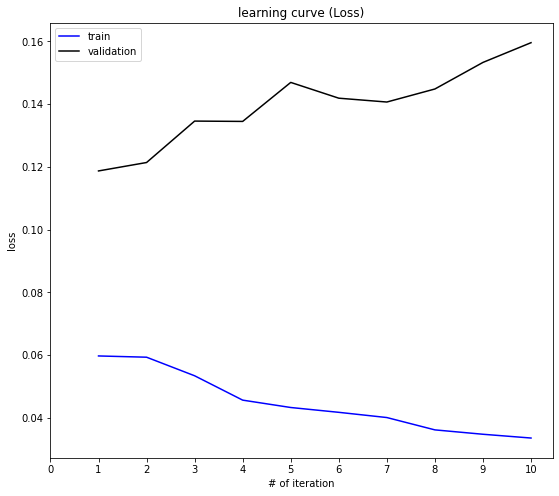

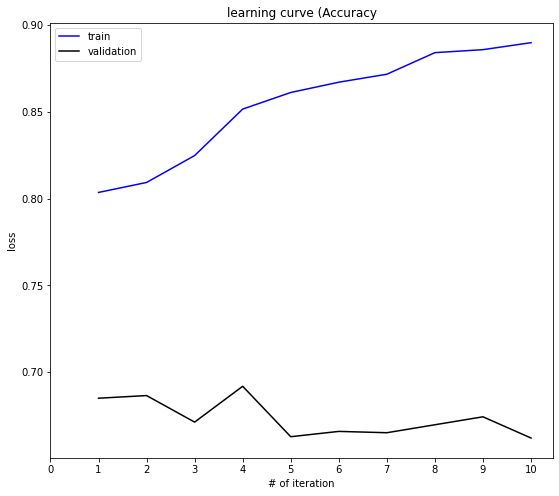

In [22]:
#Check the learning curve and acuuracy imporovements since couldn't use tensorboard
import matplotlib.pyplot as plt
evaluate_history(history)

In [55]:
def predict(trained_model, test_loader) -> torch.tensor:
    """prediction with model and test_loader, returns list of prediction result, assume to be used for inference ONLY"""  
    trained_model.to(tc.device)
    trained_model.eval()
    
    predictions = torch.tensor([]).to(tc.device)
    for i, inputs in enumerate(test_loader):
        inputs = inputs.to(tc.device)
        outputs = trained_model(inputs)
        # get the predicted result by index number, each prediction will be done by tc.batch_size so predicted is array of batch_size
        predictions = torch.hstack((predictions, torch.max(outputs, axis=1)[1]))
    return predictions


In [57]:
# Now do the inference and get submission.csv file
test_dataset = KenyanFood13Testset()
test_loader = DataLoader(test_dataset, batch_size = tc.batch_size, shuffle = False)

# prediction
predicted_result = predict(model, test_loader).tolist()
#print("predicted_result len:{}".format(len(predicted_result)))
classifications = []

#change predicted index to class_names
for index in range(len(predicted_result)):
    predicted_result_class = test_dataset.base_dataset.index2class(int(predicted_result[index]))
    classifications.append(predicted_result_class)

# put it to csv file
classes = pd.DataFrame(classifications, columns = ["class"])
result = test_dataset.test_labels.join(classes)
result.to_csv(tc.submission_csv, index=False, header = True)

predicted_result len:1638


## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**